# Image Inpainting

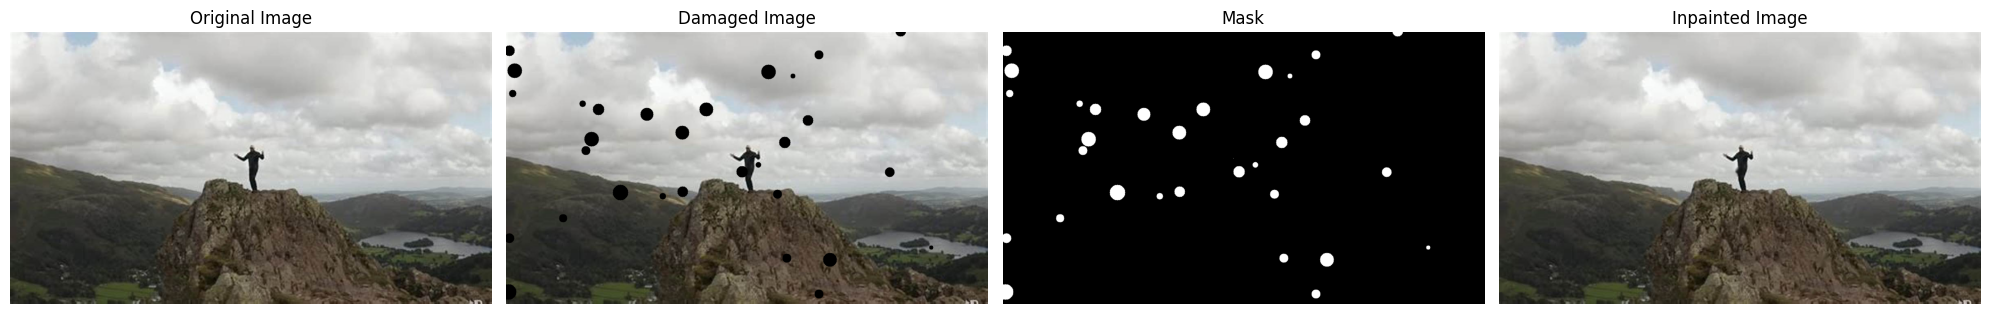

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the original image
img = cv2.imread('person.jpg')
damaged_img = img.copy()

# Add artificial damage: black circles (simulate missing parts)
for _ in range(30):  # number of anomalies
    x = np.random.randint(0, damaged_img.shape[1])
    y = np.random.randint(0, damaged_img.shape[0])
    radius = np.random.randint(5, 20)
    cv2.circle(damaged_img, (x, y), radius, (0, 0, 0), -1)

# Create a mask: white where damaged (black pixels), black elsewhere
mask = np.zeros_like(damaged_img)
height, width = mask.shape[:2]
for i in range(height):
    for j in range(width):
        if np.all(damaged_img[i, j] == [0, 0, 0]):
            mask[i, j] = [255, 255, 255]
        else:
            mask[i, j] = [0, 0, 0]

# Convert to grayscale mask for inpainting
gray_mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

# Inpaint the image
inpainted = cv2.inpaint(damaged_img, gray_mask, 3, cv2.INPAINT_NS)

# Convert images from BGR to RGB for plotting with matplotlib
original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
damaged_rgb = cv2.cvtColor(damaged_img, cv2.COLOR_BGR2RGB)
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
inpainted_rgb = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)

# Plot all steps using matplotlib
plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(original_rgb)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Damaged Image")
plt.imshow(damaged_rgb)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Mask")
plt.imshow(mask_rgb)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.title("Inpainted Image")
plt.imshow(inpainted_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()


# Image Stiching

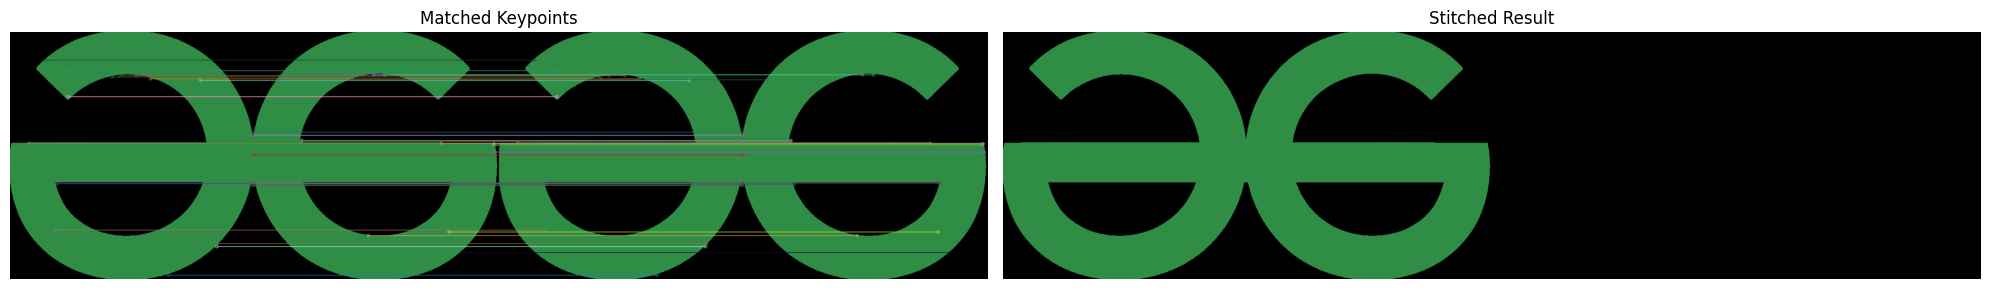

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read input images
img1 = cv2.imread('gfg1.png')
img2 = cv2.imread('gfg2.png')

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Use BFMatcher to find matches
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)

# Sort matches by distance
matches = sorted(matches, key=lambda x: x.distance)
img_matches = cv2.drawMatches(
    img1, kp1, img2, kp2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Extract location of good matches
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Compute homography
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

if H is not None:
    # Get dimensions of the images
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Warp image2 to image1's plane
    pts = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    dst = cv2.perspectiveTransform(pts, H)

    img2_warped = cv2.warpPerspective(img2, H, (w1 + w2, h1))

    # Place image1 onto the warped image2
    img2_warped[0:h1, 0:w1] = img1
    result = img2_warped

    # Convert BGR to RGB for display
    img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    # Plot the result
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(img_matches_rgb)
    plt.title("Matched Keypoints")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result_rgb)
    plt.title("Stitched Result")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("Homography could not be computed. Try with images having more overlap or better features.")


# Panorma Stiching

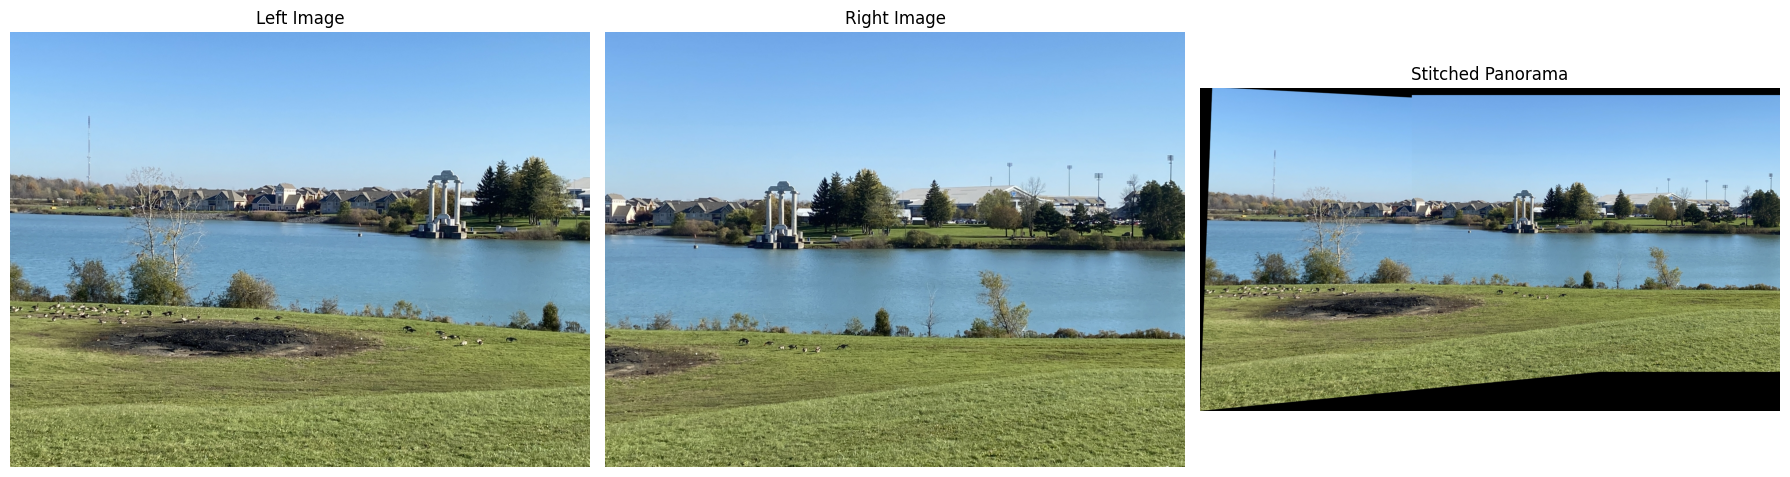

In [6]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

def solution(left_img, right_img):
    key_points1, descriptor1, key_points2, descriptor2 = get_keypoint(left_img, right_img)
    good_matches = match_keypoint(key_points1, key_points2, descriptor1, descriptor2)
    final_H = ransac(good_matches)

    rows1, cols1 = right_img.shape[:2]
    rows2, cols2 = left_img.shape[:2]

    # corners of right image (to remain unchanged)
    points1 = np.float32([[0, 0], [0, rows1], [cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    # corners of left image (to be warped)
    points2 = np.float32([[0, 0], [0, rows2], [cols2, rows2], [cols2, 0]]).reshape(-1, 1, 2)
    warped_points2 = cv2.perspectiveTransform(points2, final_H)

    # find bounds of final stitched image
    all_points = np.concatenate((points1, warped_points2), axis=0)
    [x_min, y_min] = np.int32(all_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(all_points.max(axis=0).ravel() + 0.5)

    # translation to shift the image if there's a negative origin
    translation = [-x_min, -y_min]
    H_translation = np.array([
        [1, 0, translation[0]],
        [0, 1, translation[1]],
        [0, 0, 1]
    ])

    # warp left image into panorama
    result_img = cv2.warpPerspective(left_img, H_translation @ final_H, (x_max - x_min, y_max - y_min))

    # paste right image into result
    result_img[translation[1]:translation[1]+rows1, translation[0]:translation[0]+cols1] = right_img

    return result_img


def get_keypoint(left_img, right_img):
    l_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY)
    r_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    key_points1, descriptor1 = sift.detectAndCompute(l_img, None)
    key_points2, descriptor2 = sift.detectAndCompute(r_img, None)
    return key_points1, descriptor1, key_points2, descriptor2

def match_keypoint(key_points1, key_points2, descriptor1, descriptor2):
    all_matches = []
    for i, d1 in enumerate(descriptor1):
        dists = []
        for j, d2 in enumerate(descriptor2):
            dist = np.linalg.norm(d1 - d2)
            dists.append((i, j, dist))
        dists.sort(key=lambda x: x[2])
        all_matches.append(dists[:2])

    good_matches = []
    for m, n in all_matches:
        if m[2] < 0.75 * n[2]:
            left_pt = key_points1[m[0]].pt
            right_pt = key_points2[m[1]].pt
            good_matches.append([left_pt[0], left_pt[1], right_pt[0], right_pt[1]])
    return good_matches

def homography(points):
    A = []
    for pt in points:
        x, y = pt[0], pt[1]
        X, Y = pt[2], pt[3]
        A.append([x, y, 1, 0, 0, 0, -X*x, -X*y, -X])
        A.append([0, 0, 0, x, y, 1, -Y*x, -Y*y, -Y])
    A = np.array(A)
    _, _, vh = np.linalg.svd(A)
    H = vh[-1].reshape(3, 3)
    return H / H[2, 2]

def ransac(good_pts, iterations=5000, threshold=5):
    best_inliers = []
    final_H = None
    for _ in range(iterations):
        random_pts = random.sample(good_pts, 4)
        H = homography(random_pts)
        inliers = []
        for pt in good_pts:
            p1 = np.array([pt[0], pt[1], 1]).reshape(3, 1)
            p2 = np.array([pt[2], pt[3], 1]).reshape(3, 1)
            Hp1 = np.dot(H, p1)
            Hp1 = Hp1 / Hp1[2]
            dist = np.linalg.norm(p2 - Hp1)
            if dist < threshold:
                inliers.append(pt)
        if len(inliers) > len(best_inliers):
            best_inliers = inliers
            final_H = H
    return final_H

if __name__ == "__main__":
    left_img = cv2.imread('left.jpg')
    right_img = cv2.imread('right.jpg')
    result_img = solution(left_img, right_img)

    # Convert BGR to RGB for display
    left_rgb = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
    right_rgb = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
    result_rgb = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    # Plotting
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(left_rgb)
    plt.title("Left Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(right_rgb)
    plt.title("Right Image")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result_rgb)
    plt.title("Stitched Panorama")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# Structure from Motion


Fundamental Matrix (F):
 [[ 4.04751484e-07 -1.15258837e-06  2.04589093e-03]
 [-3.34052035e-07  9.11184603e-08 -7.17473788e-03]
 [-2.07045490e-03  7.69351131e-03  1.00000000e+00]]

Essential Matrix (E):
 [[-0.00348333 -0.05994559 -0.02780789]
 [-0.05360574  0.00813158 -0.7044924 ]
 [ 0.01632761  0.70433276  0.00454466]]

Recovered Rotation (R):
 [[ 0.98690504  0.01705896 -0.16039771]
 [-0.01521813  0.99980356  0.01269817]
 [ 0.16058282 -0.01009094  0.98697079]]

Recovered Translation (t):
 [[-0.99561149]
 [ 0.03874949]
 [-0.08518361]]


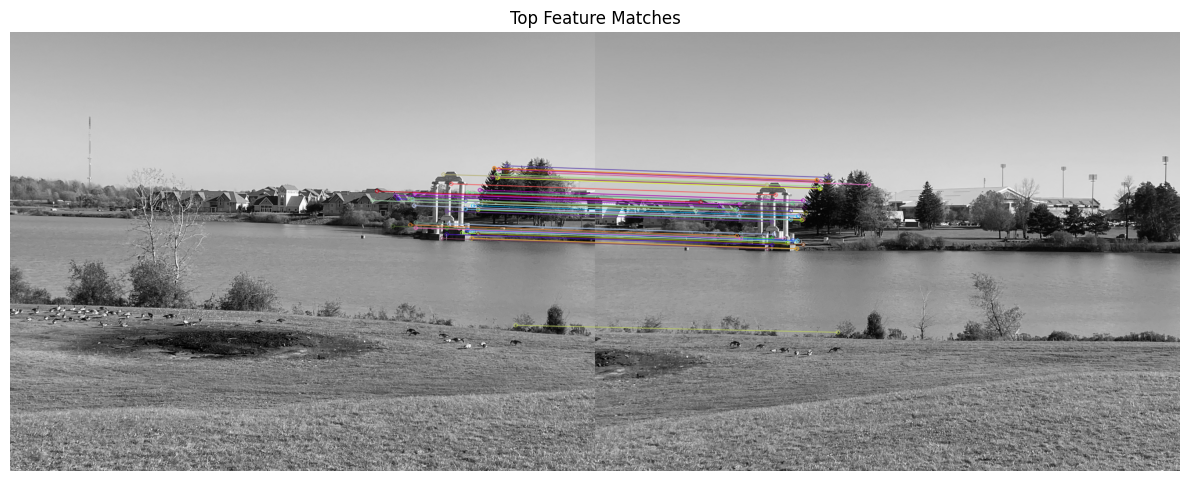

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load two images from different viewpoints
img1 = cv2.imread('left.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('right.jpg', cv2.IMREAD_GRAYSCALE)

# Ensure images loaded
assert img1 is not None and img2 is not None, "Images not loaded. Check paths."

# 1. Detect ORB keypoints and descriptors
orb = cv2.ORB_create(5000)
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# 2. Match descriptors using BFMatcher with Hamming distance
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Draw top 50 matches for visualization
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:50], None, flags=2)

# 3. Extract matched points
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

# 4. Estimate the Fundamental matrix
F, mask_F = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# 5. Estimate the Essential matrix (requires known camera intrinsics)
# Use a dummy intrinsic matrix K for demonstration
K = np.array([[800, 0, img1.shape[1] / 2],
              [0, 800, img1.shape[0] / 2],
              [0,   0, 1]])

E, mask_E = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)

# 6. Recover relative camera pose from Essential matrix
_, R, t, mask_pose = cv2.recoverPose(E, pts1, pts2, K)

# Print results
print("Fundamental Matrix (F):\n", F)
print("\nEssential Matrix (E):\n", E)
print("\nRecovered Rotation (R):\n", R)
print("\nRecovered Translation (t):\n", t)

# Visualize matches
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.title("Top Feature Matches")
plt.axis('off')
plt.tight_layout()
plt.show()
